### Mediapipe & OpenCV project : Drowsiness Detection (Image Test)

In [1]:
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

In [3]:
# mediapipe를 이용해 양쪽 눈에 대한 landmark(index) 포인트를 가져옴

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

font = cv2.FONT_ITALIC

##### FaceMash 눈 감지 test

In [4]:
# EAR에 사용할 12개의(각각 6개) landmark points 지정 :   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [5]:
def get_facemesh(
                max_num_faces=1,                # 감지할 얼굴 수
                refine_landmarks=False,         # 눈 외의 landmark는 세분화시키지 않음
                min_detection_confidence=0.07,   # 얼굴 인식에 성공한 것으로 간주되는 최소 신뢰도
                min_tracking_confidence= 0.2    # 성공적으로 추적한 것으로 간주되는 최소 신뢰도
):
    face_mesh = mp_facemesh.FaceMesh(
        max_num_faces=max_num_faces,
        refine_landmarks=refine_landmarks,
        min_detection_confidence=min_detection_confidence,
        min_tracking_confidence=min_tracking_confidence
    )

    return face_mesh

In [6]:
def distance(point_1, point_2):
    # L2 norm 계산 (두 벡터 사이의 거리 계산)
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

In [7]:
# EAR 공식 적용

def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    # landmarks : 검출된 lanmarks list
    # refer_idxs : 검출을 위해 지정한 landmarks list [index]

    try:
        # 수평 거리 계산
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y, frame_width, frame_height)
            coords_points.append(coord)
 
        # EAR 공식에 맞춰 P2-P6, P3-P5, P1-P4를 연산함
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])
 
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)
 
    except:
        ear = 0.0
        coords_points = None
 
    return ear, coords_points

In [8]:
def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    
    # 왼쪽 눈의 EAR 값과 landmarks의 좌표 값을 반환함
    left_ear, left_lm_coordinates = get_ear(
                                      landmarks, 
                                      left_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    
    # 오른쪽 눈의 EAR 값과 landmarks의 좌표 값을 반환함
    right_ear, right_lm_coordinates = get_ear(
                                      landmarks, 
                                      right_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    # 최종 EAR 값을 얻기 위해 왼쪽 오른쪽의 EAR 값 평균을 계산함
    Avg_EAR = (left_ear + right_ear) / 2.0
 
    return Avg_EAR, (left_lm_coordinates, right_lm_coordinates)

In [9]:
def plot_eye_landmarks(frame, left_lm_coordinates, 
                       right_lm_coordinates, color
                       ):
    for lm_coordinates in [left_lm_coordinates, right_lm_coordinates]:
        if lm_coordinates:
            for coord in lm_coordinates:
                cv2.circle(frame, coord, 2, color, -1)
 
    # frame = cv2.flip(frame, 1)
    return frame

In [10]:
# import cv2

# webcam = cv2.VideoCapture(0)

# # webcam = cv2.VideoCapture('d:/drowsiness_video_data/SGA2100300S0042.mp4')
# webcam.set(cv2.CAP_PROP_FRAME_WIDTH, 640) #1920
# webcam.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) #1080

# if not webcam.isOpened():
#     print("Could not open webcam")
#     exit()

# cnt=0

# while webcam.isOpened():
#     status, frame = webcam.read()
#     if status:
#         f_H, f_W, _ = frame.shape
#         # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#         facemesh_model = get_facemesh()
#         results = facemesh_model.process(frame)
#         # print(results.multi_face_landmarks) 

#         if results.multi_face_landmarks:
#             for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                
#                 ######################################################### 얼굴 전체 landmark 그리기
#                 # connections_drawing_spec = mp_drawing.DrawingSpec(
#                 #     thickness=1, 
#                 #     circle_radius=2, 
#                 #     color=(255, 255, 255)
#                 # )

#                 # mp_drawing.draw_landmarks(
#                 #     image=frame,
#                 #     landmark_list=face_landmarks,
#                 #     connections=mp_facemesh.FACEMESH_TESSELATION,
#                 #     landmark_drawing_spec=None,
#                 #     connection_drawing_spec=connections_drawing_spec,
#                 # )
#                 ##########################################################


#                 landmarks = face_landmarks.landmark
                
#                 EAR,coordinates = calculate_avg_ear(
#                         landmarks,
#                         chosen_left_eye_idxs,
#                         chosen_right_eye_idxs,
#                         f_W,
#                         f_H
#                         )
                

#                 ########################################################### Pytorch model 적용을 위해 eye 영역 검출 (P1, P4)
#                 eye = frame[coordinates[1][0][0]-10 : coordinates[0][3][0]+10, coordinates[1][2][1]-10 : coordinates[0][4][1]+10]
#                 print(eye)
#                 # eye = cv2.resize(eye,(64,64))
                
                
#                 cv2.putText(frame,
#                             f"EAR: {round(EAR, 2)}", 
#                             #(1, 24),
#                             (550,250),
#                             cv2.FONT_HERSHEY_COMPLEX, 
#                             0.9, (255, 255, 255), 2)

#                 frame = plot_eye_landmarks(frame, 
#                                         coordinates[0], 
#                                         coordinates[1],
#                                         (0, 255, 0),
#                                         )           

#         cv2.imshow("test", frame)
#         # cnt+=1

#     if cv2.waitKey(1) & 0xFF == ord('q'): # 0또는 1의 경우 계속적으로 읽어옴, 영상 frame 단위로 waitKey 지정
#         break

# webcam.release()
# cv2.destroyAllWindows()
# # print(cnt)

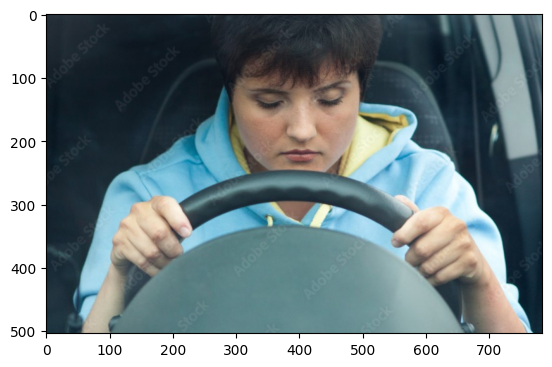

In [11]:
# load the image
image = cv2.imread('d:/drowsiness_video_data/image/test3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB
image = np.ascontiguousarray(image) # 데이터를 빠르게 불러오기 위해 사용
imgH, imgW, _ = image.shape
 
plt.imshow(image)

In [12]:
# FaceMash 설정

with mp_facemesh.FaceMesh(
    static_image_mode=True,         # Default=False
    max_num_faces=1,                # 감지할 얼굴 수
    refine_landmarks=False,         # 눈 외의 landmark는 세분화시키지 않음
    min_detection_confidence=0.5,   # 얼굴 인식에 성공한 것으로 간주되는 최소 신뢰도
    min_tracking_confidence= 0.5,   # 성공적으로 추적한 것으로 간주되는 최소 신뢰도
) as face_mesh:
     
    results = face_mesh.process(image)
 
# 감지된 landmark points 목록
# print(bool(results.multi_face_landmarks))
results.multi_face_landmarks

[landmark {
   x: 0.5177794694900513
   y: 0.4275703430175781
   z: -0.017027148976922035
 }
 landmark {
   x: 0.5193924307823181
   y: 0.39071276783943176
   z: -0.05364353582262993
 }
 landmark {
   x: 0.5172997117042542
   y: 0.39808401465415955
   z: -0.022428415715694427
 }
 landmark {
   x: 0.5081782937049866
   y: 0.3370668888092041
   z: -0.04969993233680725
 }
 landmark {
   x: 0.5195655822753906
   y: 0.37681910395622253
   z: -0.05968714505434036
 }
 landmark {
   x: 0.5189046263694763
   y: 0.35496658086776733
   z: -0.05905594676733017
 }
 landmark {
   x: 0.516244113445282
   y: 0.2969842255115509
   z: -0.041715074330568314
 }
 landmark {
   x: 0.43356025218963623
   y: 0.2792079448699951
   z: -0.007291658315807581
 }
 landmark {
   x: 0.5153840780258179
   y: 0.2568291425704956
   z: -0.04275771602988243
 }
 landmark {
   x: 0.5153689980506897
   y: 0.23652616143226624
   z: -0.0496603399515152
 }
 landmark {
   x: 0.513360321521759
   y: 0.1515941470861435
   z: -0.05

In [13]:
############################# 시각화 
# 1. drawing_utils를 통해 감지된 모든 landmarks 표시
# 2. 모든 eye landmarks 표시
# 3. 지정한 eye landmarks(12개) 표시

def plot(img_dt, img_eye_lmks_chosen=None, face_landmarks=None, lmk_circle_radius=3):

    # chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen
 
    fig = plt.figure(figsize=(20, 15))
    fig.set_facecolor("white")
 
    # 각 landmark에 대한 x,y,z 좌표값
    landmarks = face_landmarks.landmark
 
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_chosen_idxs: # 지정한 eye landmarks에 해당하는 경우
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
    plt.imshow(img_eye_lmks_chosen)
    plt.title("Chosen landmarks", fontsize=18)
    plt.show()
    plt.close()
    return

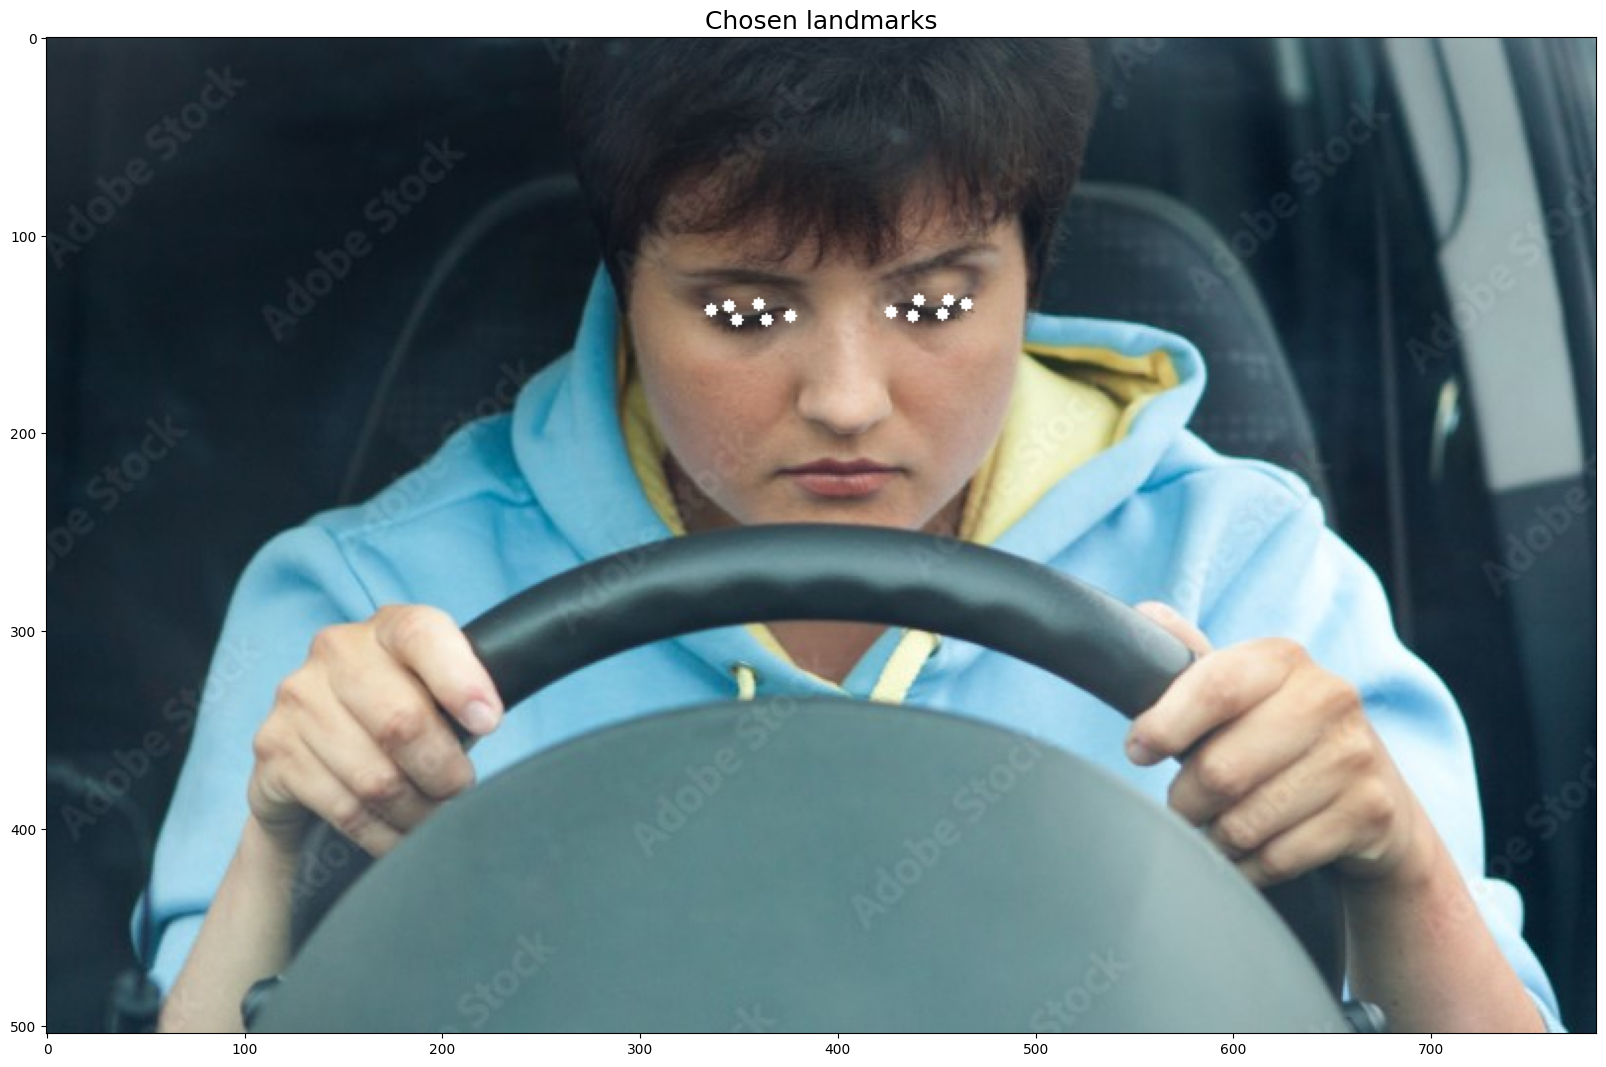

In [14]:
if results.multi_face_landmarks:
    for face_id, face_landmarks in enumerate(results.multi_face_landmarks):    
        plot(img_dt=image.copy(), face_landmarks=face_landmarks)

##### EAR 적용
    - Mediapipe의 FaceMesh를 사용해 눈 영역의 landmarks를 감지함 (관련 논문을 바탕으로 6개의 지정만 사용)
    - 눈의 높이와 너비 사이에서 EAR(Eye aspect ratio)를 계산함
    - EAR 값이 0에 가깝게 급격히 감소하는 경우 눈을 감았다고 판단함

In [15]:
def distance(point_1, point_2):
    # L2 norm 계산 (두 벡터 사이의 거리 계산)
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

In [16]:
# EAR 공식 적용

def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    # landmarks : 검출된 lanmarks list
    # refer_idxs : 검출을 위해 지정한 landmarks list [index]

    try:
        # 수평 거리 계산
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y, frame_width, frame_height)
            coords_points.append(coord)
 
        # EAR 공식에 맞춰 P2-P6, P3-P5, P1-P4를 연산함
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])
 
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)
 
    except:
        ear = 0.0
        coords_points = None
 
    return ear, coords_points

In [17]:
def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    
    # 왼쪽 눈의 EAR 값과 landmarks의 좌표 값을 반환함
    left_ear, left_lm_coordinates = get_ear(
                                      landmarks, 
                                      left_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    
    # 오른쪽 눈의 EAR 값과 landmarks의 좌표 값을 반환함
    right_ear, right_lm_coordinates = get_ear(
                                      landmarks, 
                                      right_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    # 최종 EAR 값을 얻기 위해 왼쪽 오른쪽의 EAR 값 평균을 계산함
    Avg_EAR = (left_ear + right_ear) / 2.0
 
    return Avg_EAR, (left_lm_coordinates, right_lm_coordinates)

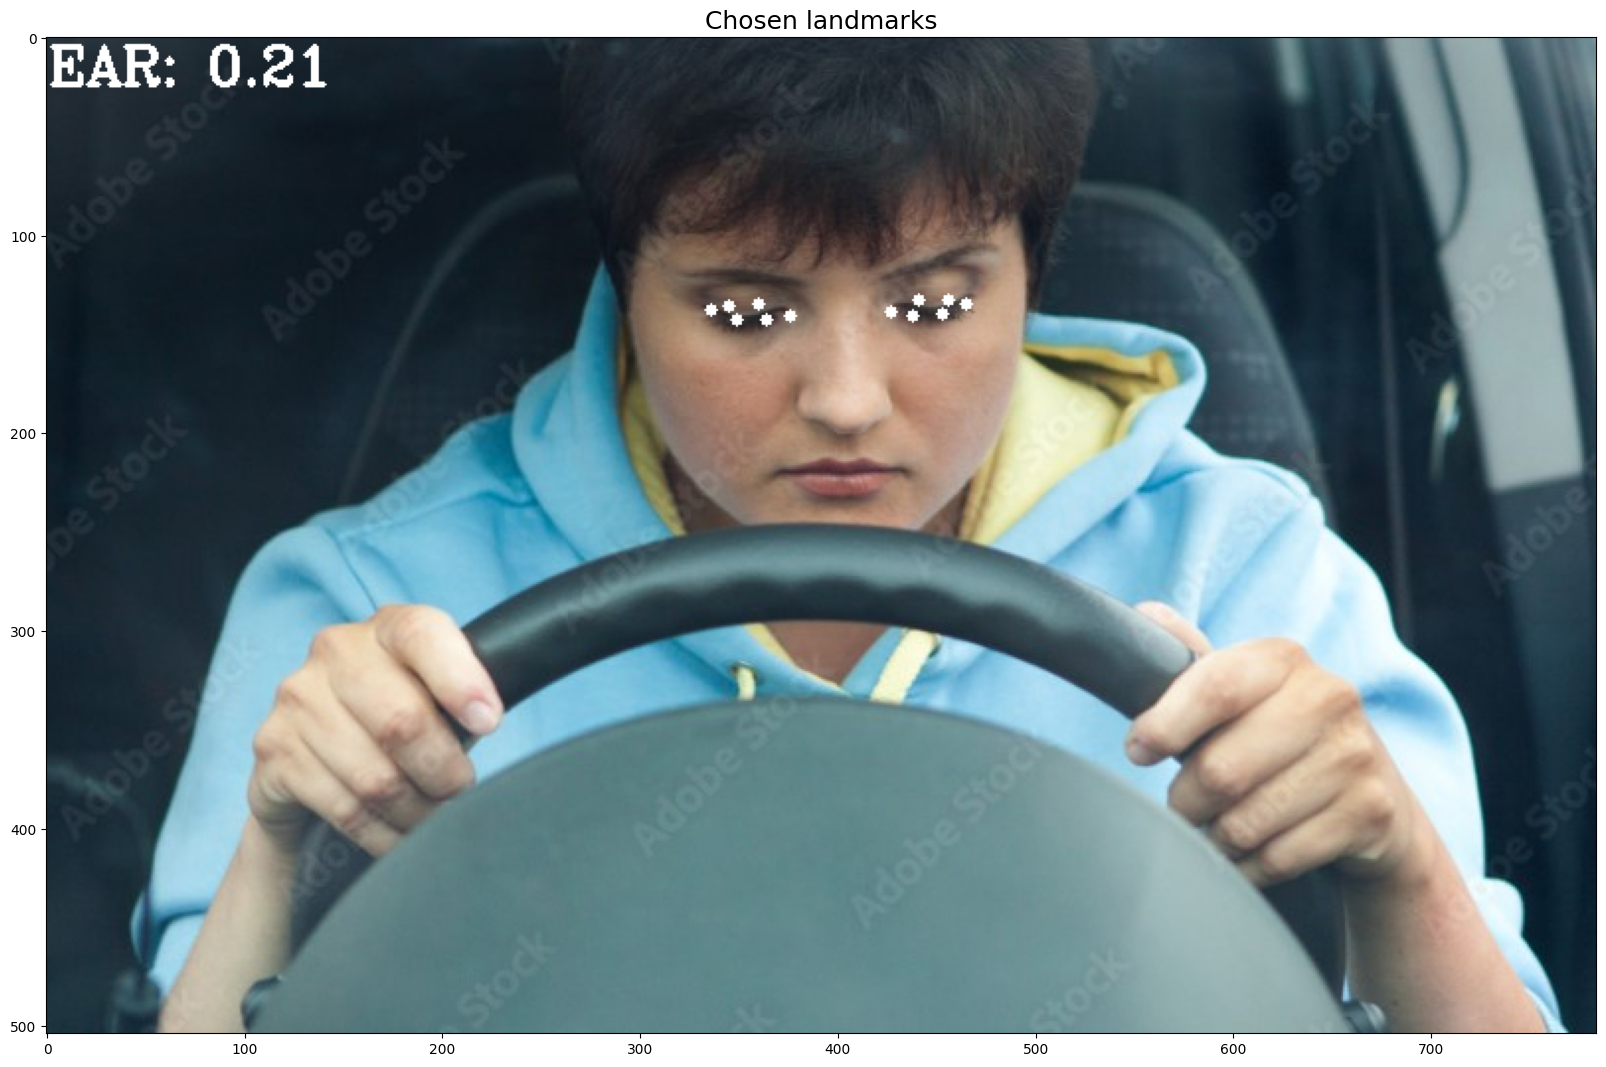

In [18]:
if results.multi_face_landmarks:
    for face_id, face_landmarks in enumerate(results.multi_face_landmarks):    
        landmarks = face_landmarks.landmark

        EAR, coordinates = calculate_avg_ear(
                landmarks,
                chosen_left_eye_idxs,
                chosen_right_eye_idxs,
                imgW,
                imgH
                )

        cv2.putText(image,
                    f"EAR: {round(EAR, 2)}", (1, 24),
                    cv2.FONT_HERSHEY_COMPLEX, 
                    0.9, (255, 255, 255), 2)

        plot(img_dt=image.copy(), face_landmarks=face_landmarks)

### 눈 영역만 검출

###### 양측 눈

(504, 784, 3)
336
465
135
140


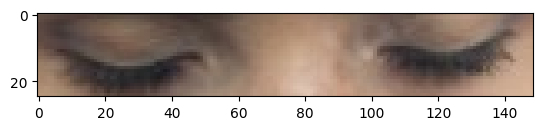

In [19]:
if results.multi_face_landmarks:
    for face_id, face_landmarks in enumerate(results.multi_face_landmarks):    
        landmarks = face_landmarks.landmark

        EAR, coordinates = calculate_avg_ear(
                landmarks,
                chosen_left_eye_idxs,
                chosen_right_eye_idxs,
                imgW,
                imgH
                )
        print(image.shape)
        print(coordinates[1][0][0])  ### 눈 영역 너비
        print(coordinates[0][3][0])
        print(coordinates[1][2][1])  ### 눈 영역 높이
        print(coordinates[0][4][1])

        # eye = image[coordinates[1][0][0]-10 : coordinates[0][3][0]+10, coordinates[1][2][1]-10 : coordinates[0][4][1]+10]
        
        eye = image[coordinates[1][2][1]-10 : coordinates[0][4][1]+10, coordinates[1][0][0]-10 : coordinates[0][3][0]+10]
        # print(eye)
        # eye = cv2.resize(eye,(64,64))
        plt.imshow(eye)
        # plt.show()

        cv2.putText(image,
                    f"EAR: {round(EAR, 2)}", (1, 24),
                    cv2.FONT_HERSHEY_COMPLEX, 
                    0.9, (255, 255, 255), 2)

        # plot(img_dt=image.copy(), face_landmarks=face_landmarks)

###### 왼쪽 오른쪽 눈

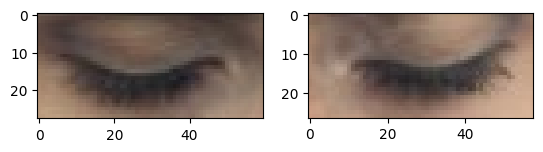

In [20]:
if results.multi_face_landmarks:
    for face_id, face_landmarks in enumerate(results.multi_face_landmarks):    
        landmarks = face_landmarks.landmark

        EAR, coordinates = calculate_avg_ear(
                landmarks,
                chosen_left_eye_idxs,
                chosen_right_eye_idxs,
                imgW,
                imgH
                )
        # print(image.shape)
        # print(coordinates[1][0][0])  ### 눈 영역 너비
        # print(coordinates[0][3][0])
        # print(coordinates[1][2][1])  ### 눈 영역 높이
        # print(coordinates[0][4][1])

        # eye = image[coordinates[1][0][0]-10 : coordinates[0][3][0]+10, coordinates[1][2][1]-10 : coordinates[0][4][1]+10]
        
        eye_right = image[coordinates[1][2][1]-10 : coordinates[1][4][1]+10, coordinates[1][0][0]-10 : coordinates[1][3][0]+10]
        eye_left = image[coordinates[0][2][1]-10 : coordinates[0][4][1]+10, coordinates[0][0][0]-10 : coordinates[0][3][0]+10]
        # print(eye)
        # eye = cv2.resize(eye,(64,64))
        plt.subplot(1,2,1)
        plt.imshow(eye_right)

        plt.subplot(1,2,2)
        plt.imshow(eye_left)
        # plt.show()

        cv2.putText(image,
                    f"EAR: {round(EAR, 2)}", (1, 24),
                    cv2.FONT_HERSHEY_COMPLEX, 
                    0.9, (255, 255, 255), 2)

        # plot(img_dt=image.copy(), face_landmarks=face_landmarks)

In [21]:
image.shape

(504, 784, 3)

#### 자른 이미지 영역에 모델 적용해보기

tensor([[ 0.4889, -0.4787]], device='cuda:0', grad_fn=<AddmmBackward0>)


'Closed_Eyes'

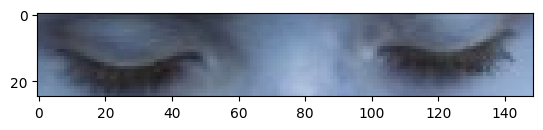

In [22]:
import torch
import torch.nn as nn
import torchsummary

from torchvision import models
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Class_Names=['Closed_Eyes', 'Open_Eyes']

# load model
model = torch.load('drowsiness_detect.pt')
model.load_state_dict(torch.load('drowsiness_detect_state_dict.pt')) 

model.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

eye_rgb = cv2.cvtColor(eye, cv2.COLOR_BGR2RGB)
eye_img = Image.fromarray(eye_rgb)

eye_img = transform(eye_img).to(device)
eye_img = eye_img.unsqueeze(0)

test_preds = model(eye_img)
print(test_preds)
predicted_class_idx = torch.argmax(test_preds, dim=1)
predicted_class_label = Class_Names[predicted_class_idx.item()]

plt.imshow(eye_rgb)
predicted_class_label

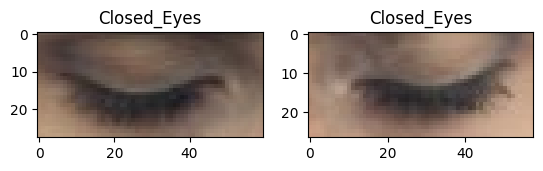

In [23]:
import torch
import torch.nn as nn
import torchsummary

from torchvision import models
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Class_Names=['Closed_Eyes', 'Open_Eyes']

# load model
model = torch.load('drowsiness_detect.pt')
model.load_state_dict(torch.load('drowsiness_detect_state_dict.pt')) 

model.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])


def predicted_label(crop_eye):
    crop_eye = cv2.cvtColor(eye, cv2.COLOR_BGR2RGB)
    eye_img = Image.fromarray(crop_eye)

    eye_img = transform(eye_img).to(device)
    eye_img = eye_img.unsqueeze(0)
    
    test_preds = model(eye_img)
    predicted_class_idx = torch.argmax(test_preds, dim=1)
    predicted_class_label = Class_Names[predicted_class_idx.item()]

    return predicted_class_label

right = predicted_label(eye_right)
left = predicted_label(eye_left)

plt.subplot(1,2,1)
plt.title(right)
plt.imshow(eye_right)

plt.subplot(1,2,2)
plt.title(left)
plt.imshow(eye_left)